# ToF Distribution Shift
The ToF distribution for a pulsating layer shifts based on concentration/saturation. For concentration, the shift is both horizontal and vertical. For saturation it seems mostly vertical. Is there any way to quantify these shifts? 

The amount of shift impacts the perceived intensity directly. We can think of the intensity v. ToF distribution approximately as the product of some static G vs. ToF distribution and the pulsating layers distribution. The Intensity perceived in our CW-NIRS at any point in time will be the Area under the Curve(Well sum over some time window).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.calculate_intensity import create_quantized_tof, create_quantized_tof_const_res

maternal_wall_thickness, uterus_thickness, wave_int = 4, 5, 1
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100

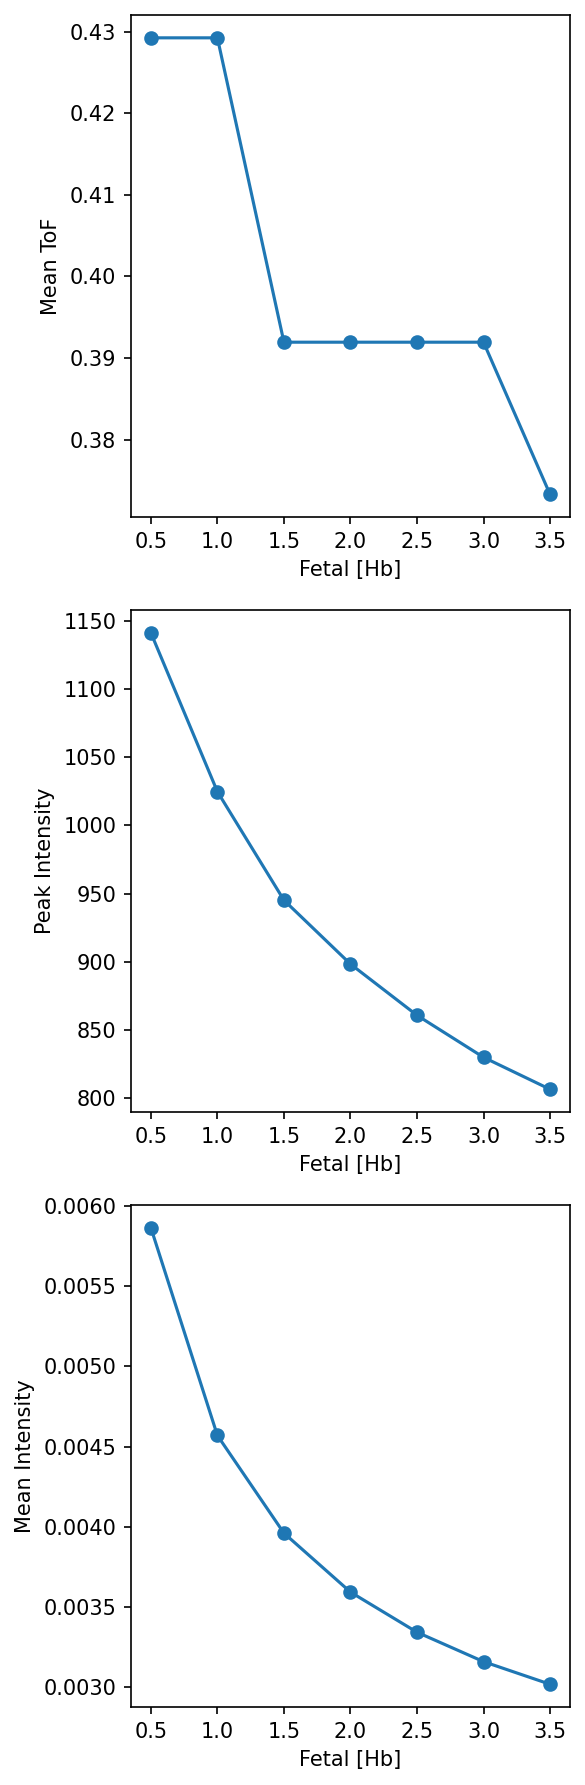

In [9]:
TIME_RESOLUTION = 4.0
SPEED_OF_LIGHT = 3e8 / 1.4
SDD_INDEX = 3

MATERNAL_Hb = 4.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225

tof_mean = []
peak_intensity = []
intensity_mean = []
all_c = np.arange(0.5, stop=4.0, step=0.5)
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
epsilon = get_mu_a(FETAL_SAT, 1, wave_int) 
all_sdd = raw_sim_data['SDD'].unique()


# plt.figure(figsize=(4, 4), dpi=900)
SDD = all_sdd[SDD_INDEX]
filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
create_quantized_tof_const_res(filtered_photon_data, TIME_RESOLUTION)
filtered_photon_data["ToF"] *= 1e6 / SPEED_OF_LIGHT

# plt.figure()
for c in all_c:
    # create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    transformed_L = np.exp(- epsilon * c * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    intensity_mean.append(np.mean(I))
    peak_intensity.append(np.max(intensity_v_L))
    tof_mean.append(intensity_v_L.idxmax())
    # line, = plt.plot(intensity_v_L, label=f'[Hb]={c} g/dL')
    # plt.fill_between(intensity_v_L.index, intensity_v_L, color=line.get_color(), alpha=0.3)

plt.figure(figsize=(4, 12), dpi=150)
plt.subplot(3,1,1)
plt.plot(all_c, tof_mean, 'o-')
plt.ylabel('Mean ToF')
plt.xlabel('Fetal [Hb]')
plt.subplot(3,1,2)
plt.plot(all_c, peak_intensity, 'o-')
plt.ylabel('Peak Intensity')
plt.xlabel('Fetal [Hb]')
plt.subplot(3,1,3)
plt.plot(all_c, intensity_mean, 'o-')
plt.ylabel('Mean Intensity')
plt.xlabel('Fetal [Hb]')
# plt.xlabel('ToF(mm/speed of light)')
# plt.ylabel('Intensity (Unnormalized)')
plt.tight_layout()
plt.show()

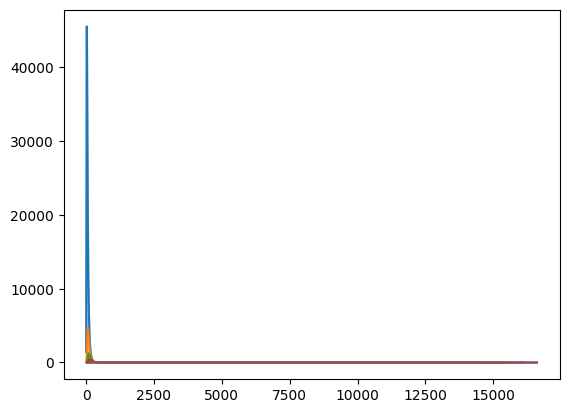

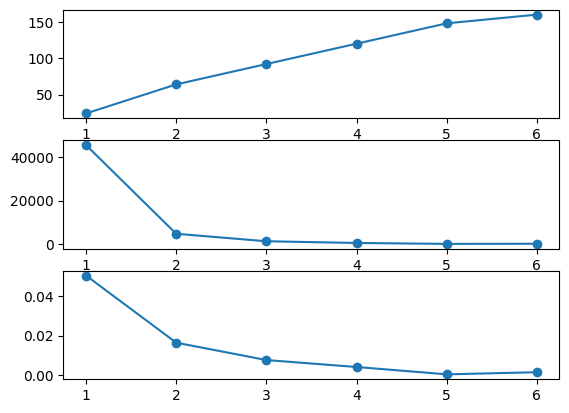

In [6]:
DIGITIZATION_BIN_COUNT = 100

SDD_INDEX = 3

MATERNAL_Hb = 4.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225

tof_mean = []
peak_intensity = []
intensity_mean = []
all_c = np.arange(0.1, stop=2.0, step=0.5)
modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
epsilon = get_mu_a(FETAL_SAT, 1, wave_int) 
all_sdd = raw_sim_data['SDD'].unique()


# plt.figure(figsize=(4, 4), dpi=900)
plt.figure()
sdd_used = [1, 2, 3, 4, 5, 6]
for sdd_index in sdd_used:
    SDD = all_sdd[sdd_index]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof_const_res(filtered_photon_data, TIME_RESOLUTION)
    # create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    transformed_L = np.exp(- epsilon * FETAL_SAT * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    intensity_mean.append(np.mean(I))
    peak_intensity.append(np.max(intensity_v_L))
    tof_mean.append(intensity_v_L.idxmax())
    line, = plt.plot(intensity_v_L, label=f'[Hb]={c} g/dL')
    plt.fill_between(intensity_v_L.index, intensity_v_L, color=line.get_color(), alpha=0.3)

plt.figure()
plt.subplot(3,1,1)
plt.plot(sdd_used, tof_mean, 'o-')
plt.subplot(3,1,2)
plt.plot(sdd_used, peak_intensity, 'o-')
plt.subplot(3,1,3)
plt.plot(sdd_used, intensity_mean, 'o-')
# plt.xlabel('ToF(mm/speed of light)')
# plt.ylabel('Intensity (Unnormalized)')
plt.show()